In [1]:
# Import Libraries
import torch
import torch.utils.data
#import torch.nn as nn
#import torch.nn.functional as Function
#import torch.optim as optim
#from torch.autograd import Variable
#from scipy import stats, integrate

import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd

In [2]:
# Path directory
path = '/Users/khanhnamle/Desktop/CSCI799-Graduate-Independent-Study/Codebase/ml-1m'

# Load datasets from MovieLens1M
movies = pd.read_csv(path + '/movies.dat', sep='::', header=None, engine='python', encoding='latin-1')
users = pd.read_csv(path + '/users.dat', sep='::', header=None, engine='python', encoding='latin-1')
ratings = pd.read_csv(path + '/ratings.dat', sep='::', header=None, engine='python', encoding='latin-1')

In [3]:
from sklearn.model_selection import train_test_split
# Split the ratings dataframe into 75% training and 25% testing
trainingset, testset = train_test_split(ratings, train_size=0.75)
print(len(trainingset), len(testset))

750156 250053


Below are several data pre-processing steps:
* Convert train and test data into NumPy arrays
* Get the total number of movies and users to make a data matrix
* Convert train and test data into PyTorch tensors
* Convert train and test data into binary values

In [4]:
# convert to array as it is quicker 
trainingset = np.array(trainingset, dtype='int')
testset = np.array(testset, dtype='int')

In [5]:
# get total number of movies and users in order to then make a matrix of the data
nb_users = int(max(max(trainingset[:,0]), max(testset[:,0])))
nb_movies = int(max(max(trainingset[:,1]), max(testset[:,1])))
print(nb_users, 'users and', nb_movies, 'movies')

6040 users and 3952 movies


In [6]:
# Converting the data into an array with users in lines and movies in columns
def convert(data):
    new_data = [] # initialise list
    for id_users in range(1, nb_users+1):
        id_movies = data[:,1][data[:,0] == id_users]
        id_ratings = data[:,2][data[:,0] == id_users]
        ratings = np.zeros(nb_movies)
        ratings[id_movies - 1] = id_ratings
        new_data.append(list(ratings))
    return new_data

# Apply "convert" function
trainingset = convert(trainingset)
testset = convert(testset)

In [7]:
# convert data into torch sensors
training_set = torch.FloatTensor(trainingset)
test_set = torch.FloatTensor(testset)

In [8]:
# convert ratings (1-5) into binary ratings 1 (liked) and 0 (not liked)
training_set[training_set == 0] = -1 # not rated
training_set[training_set == 1] = 0
training_set[training_set == 2] = 0
training_set[training_set >= 3] = 1

test_set[test_set == 0] = -1 # not rated
test_set[test_set == 1] = 0
test_set[test_set == 2] = 0
test_set[test_set >= 3] = 1

Build the Restricted Boltzmann Machines class:
* 1 layer of visible units (users' movie preferences whose states we know and set)
* 1 layer of hidden units (the latent factors we try to learn)
* A bias unit (adjust for the different inherent popularities of each movie)

In [9]:
# Create the architecture of the Restricted Boltzmann Machine
class RBM():
    def __init__(self, n_vis, n_hid):
        
        '''
        Initialize the parameters (weights and biases) we optimize during the training process
        @self: the class object
        @n_vis: number of visible units
        @n_hid: number of hidden units
        '''
        
        # Weights used for the probability of the visible units given the hidden units
        self.W = torch.randn(n_hid, n_vis) # torch.rand: random normal distribution mean = 0, variance = 1
        
        # Bias probability of the visible units is activated, given the value of the hidden units (p_v_given_h)
        self.v_bias = torch.randn(1, n_vis) # fake dimension for the batch = 1
        
        # Bias probability of the hidden units is activated, given the value of the visible units (p_h_given_v)
        self.h_bias = torch.randn(1,n_hid) # fake dimension for the batch = 1
    
    def sample_h(self, x):
        
        '''
        Sample the hidden units
        '''
        
        # Probability h is activated given that the value v is sigmoid(Wx + a)
        # torch.mm make the product of 2 tensors
        # W.t() take the transpose because W is used for the p_v_given_h
        wx = torch.mm(x, self.W.t())
        
        # Expand the mini-batch
        activation = wx + self.h_bias.expand_as(wx)
        
        # Calculate the probability p_h_given_v
        p_h_given_v = torch.sigmoid(activation)
        
        # Bernouilli RBM to predict whether an user loves the movie or not (0 or 1)
        # This correspnds to whether the n_hid is activated or not activated
        return p_h_given_v, torch.bernoulli(p_h_given_v)
    
    def sample_v(self, y):
        
        '''
        Sample the visible units
        '''
        
        # Probability v is activated given that the value h is sigmoid(Wx + a)
        wy = torch.mm(y, self.W)
        
        # Expand the mini-batch
        activation = wy + self.v_bias.expand_as(wy)
        
        # Calculate the probability p_v_given_h
        p_v_given_h = torch.sigmoid(activation)
        
        # Bernouilli RBM to predict whether an user loves the movie or not (0 or 1)
        # This correspnds to whether the n_vis is activated or not activated
        return p_v_given_h, torch.bernoulli(p_v_given_h)
    
    def train(self, v0, vk, ph0, phk):
        
        '''
        Perform contrastive divergence algorithm to optimize the weights that minimize the energy
        This maximizes the log-likelihood of the model
        '''
        
        # Approximate the gradients with the CD algorithm
        self.W += (torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)).t()
        
        # Add , 0 for the tensor of 2 dimensions
        self.v_bias = torch.sum((v0 - vk), 0)
        self.h_bias = torch.sum((ph0 - phk), 0)

Create the RBM Object

In [10]:
# Number of movies
n_vis = len(training_set[0])

# This tunable parameter is the number of features that we want to detect (genre, actors, director, oscar, date....)
n_hid = 100

# Creation of the object of the class RBM()
rbm = RBM(n_vis, n_hid)

# Use Stochastic Gradient Descent to minimize the loss function
#train_op = optim.SGD(rbm.parameters(), 0.1)

In [11]:
batch_size_ = 100 # set batch size to be 100 (tunable)
reconerr = [] # keep track of reconstruction error
#feerror = [] # keep track of free energy loss

Train the RBM

In [12]:
# Keep track of time
start_training_time = time.time()

In [13]:
# Run for 200 epochs
nb_epoch = 200 # upper bound is not included (nb_epoch + 1)

# First for loop - go through every single epoch
for epoch in range(1, nb_epoch + 1):
    #loss_ = []
    train_recon_error = 0 # reconstruction error initialized to 0 at the beginning of training
    s = 0. # a counter (float type)
    
    # Second for loop - go through every single user
    # Lower bound is 0, upper bound is (nb_users - batch_size_), batch_size_ is the step of each batch (100)
    # The 1st batch is for user with ID = 0 to user with ID = 99
    for id_user in range(0, nb_users - batch_size_, batch_size_):
        
        # At the beginning, v0 = vk. Then we update vk 
        vk = training_set[id_user:id_user + batch_size_]
        #vk = Variable(vk)
        v0 = training_set[id_user:id_user + batch_size_]
        #v0 = Variable(v0)
              
        ph0, _ = rbm.sample_h(v0)
        
        # Third for loop - perform contrastive divergence
        for k in range(10):
            _, hk = rbm.sample_h(vk)
            _, vk = rbm.sample_v(hk)
            
            # We don't want to learn when there is no rating by the user
            # There is no update when rating = -1
            vk[v0 < 0] = v0[v0 < 0]
            
        phk, _ = rbm.sample_h(vk)
        
        # Calculate the loss using contrastive divergence
        # loss = rbm.contrastive_divergence(v0) - rbm.contrastive_divergence(vk)
        rbm.train(v0, vk, ph0, phk)
        #loss_.append(loss.data)
        #train_op.zero_grad()
        #loss.backward()
        #train_op.step()
    
        # Compare vk updated after the traning to v0 (the target)
        train_recon_error += torch.mean(torch.abs(v0[v0 >= 0] - vk[v0 >= 0]))
        s += 1.
    
    # Update reconstruction error
    reconerr.append(train_recon_error / s)
    # Update free energy loss
    #feerror.append(np.mean(loss_))
    
    print('Epoch: ' + str(epoch) + '- Reconstruction Error: ' + str(train_recon_error.data.numpy() / s))
    print("--- Training time is %s seconds ---" % (time.time() - start_training_time))

Epoch: 1- Reconstruction Error: 0.36765705744425453
--- Training time is 19.222163915634155 seconds ---
Epoch: 2- Reconstruction Error: 0.37846848169962566
--- Training time is 34.249520778656006 seconds ---
Epoch: 3- Reconstruction Error: 0.39547290802001955
--- Training time is 47.53167366981506 seconds ---
Epoch: 4- Reconstruction Error: 0.401895809173584
--- Training time is 60.612146854400635 seconds ---
Epoch: 5- Reconstruction Error: 0.40025993982950847
--- Training time is 73.70879983901978 seconds ---
Epoch: 6- Reconstruction Error: 0.3980916341145833
--- Training time is 86.23348188400269 seconds ---
Epoch: 7- Reconstruction Error: 0.4017264684041341
--- Training time is 100.20252966880798 seconds ---
Epoch: 8- Reconstruction Error: 0.40320863723754885
--- Training time is 112.76654696464539 seconds ---
Epoch: 9- Reconstruction Error: 0.40470927556355796
--- Training time is 126.17099475860596 seconds ---
Epoch: 10- Reconstruction Error: 0.40340054829915367
--- Training time 

Epoch: 81- Reconstruction Error: 0.4025699615478516
--- Training time is 1226.2153987884521 seconds ---
Epoch: 82- Reconstruction Error: 0.4025786717732747
--- Training time is 1240.1823217868805 seconds ---
Epoch: 83- Reconstruction Error: 0.40398464202880857
--- Training time is 1253.7858357429504 seconds ---
Epoch: 84- Reconstruction Error: 0.40333544413248695
--- Training time is 1266.924974679947 seconds ---
Epoch: 85- Reconstruction Error: 0.402970822652181
--- Training time is 1282.2455689907074 seconds ---
Epoch: 86- Reconstruction Error: 0.40345834096272787
--- Training time is 1297.1315636634827 seconds ---
Epoch: 87- Reconstruction Error: 0.4035205841064453
--- Training time is 1310.8785626888275 seconds ---
Epoch: 88- Reconstruction Error: 0.4032505671183268
--- Training time is 1331.4082958698273 seconds ---
Epoch: 89- Reconstruction Error: 0.4030079205830892
--- Training time is 1345.3929648399353 seconds ---
Epoch: 90- Reconstruction Error: 0.4039089520772298
--- Trainin

Epoch: 160- Reconstruction Error: 0.40274225870768227
--- Training time is 2508.9294097423553 seconds ---
Epoch: 161- Reconstruction Error: 0.40355027516682945
--- Training time is 2524.1822566986084 seconds ---
Epoch: 162- Reconstruction Error: 0.403173287709554
--- Training time is 2537.055937767029 seconds ---
Epoch: 163- Reconstruction Error: 0.4033798853556315
--- Training time is 2549.7349588871 seconds ---
Epoch: 164- Reconstruction Error: 0.4028077761332194
--- Training time is 2564.495271921158 seconds ---
Epoch: 165- Reconstruction Error: 0.40306584040323895
--- Training time is 2581.7260978221893 seconds ---
Epoch: 166- Reconstruction Error: 0.4023621877034505
--- Training time is 2595.8094437122345 seconds ---
Epoch: 167- Reconstruction Error: 0.4033037185668945
--- Training time is 2613.626754760742 seconds ---
Epoch: 168- Reconstruction Error: 0.4025904655456543
--- Training time is 2627.5166568756104 seconds ---
Epoch: 169- Reconstruction Error: 0.4020807902018229
--- Tr

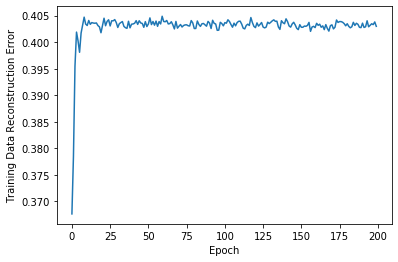

In [14]:
# Plot the recostruction error with respect to increasing number of epochs
plt.plot(reconerr)
plt.ylabel('Training Data Reconstruction Error')
plt.xlabel('Epoch')
plt.show()

In [15]:
# Keep track of time
start_test_time = time.time()

In [16]:
# Testing
test_recon_error = 0 # reconstruction error initialized to 0 at the beginning of training
s = 0. # a counter (float type) 
# test_free_energy_loss = []

for id_user in range(nb_users): # batch learning
    v = training_set[id_user:id_user + 1]  # training set inputs are used to activate neurons of my RBM
    vt = test_set[id_user:id_user + 1] # target
    
    #v = Variable(v)
    #vt = Variable(vt)
    
    if len(vt[vt >= 0]) > 0:
        _, h = rbm.sample_h(v)
        _ ,v = rbm.sample_v(h)
        
        # Update test reconstruction error
        test_recon_error += torch.mean(torch.abs(vt[vt >= 0] - v[vt >= 0]))
        s += 1.
    
    #v = v.data.numpy()
    #test_free_energy_loss.append(v)

print ('Reconstructions error:  ' +  str(test_recon_error.data.numpy() / s))
print("--- Test time is %s seconds ---" % (time.time() - start_test_time))

Reconstructions error:  0.42058368737835433
--- Test time is 3.172278881072998 seconds ---
